# Deep Learning-Based Trading Agent for Cryptocurrency: Performance Analysis and Evaluation

## Project Description

This project aims to develop a trading agent using the Proximal Policy Optimization (PPO) algorithm to make trading decisions in the cryptocurrency market. The trading agent will be trained and evaluated using historical price data of Ethereum (ETH) with a timeframe of 15 minutes.

### Code Steps

1. **Data Preprocessing**: The historical price data of Ethereum is loaded from a CSV file and preprocessed. Technical indicators such as Simple Moving Average (SMA), Relative Strength Index (RSI), Bollinger Bands (BB), Stochastic Oscillator, Exponential Moving Average (EMA), and Average True Range (ATR) are calculated and added to the dataset.

2. **Train and Test sets**: The dataset is divided into train and test sets (80% train and 20% test). it is possible to implement a K-fold Cross-Validation

3. **Training and Evaluation Loop**: A `TradingEnvironment` is created for the training set and the validation set. The environment is wrapped with `DummyVecEnv` to convert it into a vectorized environment. The PPO model is then initialized with the `"MlpPolicy"` and trained on the training environment using the PPO algorithm. After training, the trained model is used to make predictions on the validation environment.

4. **Test Results Saving**: The test results, including the date, open, high, low, close prices, volume, technical indicators, actions taken by the agent, stop-loss levels, take-profit levels, and balance, are saved in separate CSV files for analysis.

### Expected Results

The expected results of this project are:

1. The PPO model will learn to make trading decisions based on the historical price data and the calculated technical indicators.

2. The test results for each fold will provide insights into the performance of the trading agent, including the actions taken, stop-loss and take-profit levels, and the final account balance.

3. By analyzing the test results, we can evaluate the effectiveness of the trained trading agent and gain insights into its performance in different market conditions.

---

## Trading Agent Performance Analysis

This section provides a comprehensive analysis and evaluation of the performance of the deep learning-based trading agent in the cryptocurrency market. The analysis includes visualizations and metrics that provide insights into the agent's trading decisions, profitability, and comparison with a buy-and-hold strategy.




### Import Necessary Libraries

In order to run the code successfully, make sure to import the following libraries:

- `os`: For interacting with the operating system.
- `gym`: OpenAI Gym for reinforcement learning environments.
- `numpy`: A numerical computing library for efficient array operations.
- `pandas`: A data manipulation library for working with structured data.
- `ta`: A library for technical analysis of financial markets.
- `stable_baselines3`: A library for reinforcement learning algorithms.
- `sklearn`: A library for machine learning and data preprocessing tasks.
- `matplotlib.pyplot`: A plotting library for visualizations.
- `mplfinance`: A module within Matplotlib for financial plotting.

Please ensure that these libraries are installed in your Python environment. If not, you can install them using the package manager `pip`. For example:

```python
pip install gym
pip install numpy
pip install pandas
pip install ta
pip install stable_baselines3
pip install scikit-learn
pip install matplotlib

In [1]:
import os  

import gym  
from gym import spaces  

import numpy as np  
import pandas as pd 
import ta  

from stable_baselines3 import PPO  
from stable_baselines3.common.vec_env import DummyVecEnv  

from sklearn.model_selection import train_test_split  

import matplotlib.pyplot as plt  
import mplfinance as mpf  

### Trading Environment Description

The `TradingEnvironment` is a custom Gym environment designed to simulate a cryptocurrency trading environment for training and evaluating trading agents. It provides an interface for the agent to observe the market, take actions, and receive rewards based on its actions.

#### Observation Space

The observation space of the environment is a 2D NumPy array of shape `(lookback, num_features)`, where:
- `lookback` is the number of previous time steps to consider for each observation.
- `num_features` is the number of features in the input data, excluding the timestamp and the target variable.

Each element in the observation represents a specific feature value at a given time step. These features can include technical indicators such as moving averages, relative strength index (RSI), Bollinger Bands (BB), stochastic oscillator, average true range (ATR), volume-weighted average price (VWAP), and exponential moving averages (EMA).

#### Action Space

The action space of the environment is a discrete space with three possible actions:
- `0`: Buy
- `1`: Sell
- `2`: Hold

The agent can choose one of these actions at each time step to perform the corresponding trading action in the market.

#### Rewards

The agent receives rewards based on its actions and the state of the market. The reward calculation is based on several factors, including the predicted price direction, price movements, and the agent's trading strategy.

Positive rewards are given when the agent makes profitable trades or makes correct predictions ab
out the price direction. Negative rewards are given for incorrect predictions or unprofitable trades.

#### Trading Mechanism

The trading mechanism in the environment follows a simulated trading process. The agent can either open a long position (buy) or a short position (sell) based on its actions. It can also choose to hold its position.

The environment tracks the agent's account balance in USD and crypto balance, as well as the position (buy, sell, or hold), purchase price, take-profit price, and trailing stop-loss price. The take-profit and stop-loss levels are calculated based on the average true range (ATR) of the current time step.

If the agent's take-profit or stop-loss level is reached, the environment closes the position and adjusts the account balance and crypto bala ce accordingly. Transaction fees are also deducted from the account balance for each trade.

#### Reset and Step Functions

The environment provides a `reset()` function that resets the environment to the initial state and returns the initial observation.

The `step(action)` function is used to perform an action in the environment. It takes an action as input and returns the next observation, reward, and a boolean flag indicating whether the episode is done. The episode is considered done when all time steps in the data have been processed.

#### Test Results Saving

The environment keeps track of various metrics during the trading process, including the date, open, high, low, close prices, volume, technical indicators, actions taken by the agent, stop-loss levels, take-profit levels, and the balance. These metrics are saved in separate CSV files for each fold of the K-fold cross-validation. The saved test results can be analyzed to evaluate the performance of the trading agent.

Please note that the environment can be customized further to include additional features, indicators, or trading mechanisms as per specific requirements.



In [2]:
# Trading Environment class

class TradingEnvironment(gym.Env):
    def __init__(self, df, lookback):
        self.last_action_time = 0
        self.profit_target = 0.02  # For example, set profit target as 5% change in price
        self.data = df
        self.lookback = lookback
        self.current_step = self.lookback
        self.num_features = len(self.data.columns) - 2
        self.action_space = spaces.Discrete(3)  # Buy, Sell, Hold
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.lookback, self.num_features), dtype=np.float32)
        self.account_balance = 10000  # initial account balance in USD
        self.crypto_balance = 10  # initial crypto balance
        self.position = None
        self.take_profit_price = None
        self.trailing_stop_loss_price = None
        self.trailing_stop_gain_price = None
        self.purchase_price = None
        self.initial_investment= None
        

        self.test_results = {
            'Date': [],
            'Open': [],
            'High': [],
            'Low': [],
            'Close': [],
            'Volume': [],
            'BB_Upper': [],
            'BB_Lower': [],
            'RSI': [],
            'Action': [],
            'Stop_Loss':[],
            'Take_Profit': [],
            'Balance': [],
            
        }
        
    def reset(self):
        self.current_step = self.lookback
        return self._get_observation()

    def _get_observation(self):
        observation = self.data.iloc[self.current_step - self.lookback:self.current_step, 1:-1].values
        return observation
        
    def _get_price_direction(self):
        current_price = self.data.iloc[self.current_step]['close']

        future_prices = self.data.iloc[self.current_step + 1:self.current_step + 20]['close']
        future_lows = self.data.iloc[self.current_step + 1:self.current_step + 20]['low']
        future_highs = self.data.iloc[self.current_step + 1:self.current_step + 20]['high']

        # Calculate ATR for the current step
        current_atr = self.data.iloc[self.current_step]['atr']

        # Set the initial take profit and stop loss levels based on ATR
        take_profit_multiplier_long = 2.5  # Multiplier for long positions
        stop_loss_multiplier_long = 1.0  # Multiplier for long positions
        take_profit_multiplier_short = 2.5  # Multiplier for short positions
        stop_loss_multiplier_short = 1.0  # Multiplier for short positions

        take_profit_price_long = current_price + (current_atr * take_profit_multiplier_long)
        stop_loss_price_long = current_price - (current_atr * stop_loss_multiplier_long)

        take_profit_price_short = current_price - (current_atr * take_profit_multiplier_short)
        stop_loss_price_short = current_price + (current_atr * stop_loss_multiplier_short)

        long_condition_met = False
        short_condition_met = False
        long_position_index = None
        short_position_index = None

        for i, (future_high) in enumerate(future_highs):
            if future_high >= take_profit_price_long:
                long_condition_met = True
                long_position_index = i
                break  # Exit the loop after the long condition is met

        for j, (future_low) in enumerate(future_lows):
            if future_low <= take_profit_price_short:
                short_condition_met = True
                short_position_index = j
                break  # Exit the loop after the short condition is met

        if long_condition_met and short_condition_met:
            if long_position_index < short_position_index:
                return 1  # Expected increase (Long position met first)
            else:
                return -1  # Expected decrease (Short position met first)
        elif long_condition_met:
            return 1  # Expected increase (Only Long position met)
        elif short_condition_met:
            return -1  # Expected decrease (Only Short position met)
        else:
            return 0  # Uncertain direction (Neither Long nor Short position met)


    def calculate_reward(self, action):
        current_price = self.data.iloc[self.current_step]['close']
        current_high = self.data.iloc[self.current_step]['high']
        current_low = self.data.iloc[self.current_step]['low']
        future_price = self.data.iloc[self.current_step + 4]['close']
        
    
        price_difference = future_price - current_price
        price_direction = self._get_price_direction()
        
        # Retrieve indicators
        current_vwap = self.data['vwap'].iloc[self.current_step]
        current_atr = self.data.iloc[self.current_step]['atr']
        current_ema_values = [self.data[f'ema_{period}'].iloc[self.current_step] for period in [10, 20, 30, 40, 50, 60]]
        current_bb_upper = self.data['bb_upper'].iloc[self.current_step]
        current_bb_lower = self.data['bb_lower'].iloc[self.current_step]
    
        # Reward initialization
        reward = 0
    
        if action == 0:  # Buy

            if self.position == 'buy':
                if price_direction > 0:
                    reward = 1
                    if current_price > current_vwap and current_price < min(current_ema_values) and current_price <= current_bb_lower:
                        reward += 0.5  # If the stop loss level is hit but is still above purchase price, it's good.
                    if self.trailing_stop_loss_price is not None and current_low <= self.trailing_stop_loss_price:
                        if self.trailing_stop_loss_price > self.purchase_price :
                            reward += 0.3  # Boost the reward
                        else:
                            reward -= 1  # Penalize the reward
                    # If the take profit level is hit, boost the reward
                    if self.take_profit_price is not None and current_high >= self.take_profit_price:
                        reward += 1 
                else:
                    reward = -1  # Penalize wrong prediction
                
            # Deduct transaction fee
            reward -=  0.001
        
        
        elif action == 1:  # Sell
            
            if self.position == "sell":  
                if price_direction < 0:
                    reward = 1
                    if current_price < current_vwap and current_price > max(current_ema_values) and current_price >= current_bb_upper:
                        reward += 0.5 # If the stop loss level is hit but is still below purchase price, it's good.
                    if self.trailing_stop_loss_price is not None and current_high >= self.trailing_stop_loss_price:
                        if self.trailing_stop_loss_price < self.purchase_price:
                            reward += 0.3  # Boost the reward
                        else:
                            reward -= 1  # Penalize the reward
                    # If the take profit level is hit, boost the reward
                    if self.take_profit_price is not None and current_low <= self.take_profit_price:
                        reward += 1
                else:
                    reward = -1  # Penalize wrong prediction
                
            # Deduct transaction fee
            reward -= 0.001

        return reward

    def _calculate_predicted_direction(self, action):
        
        # Calculate the predicted direction based on the agent's action
        if action == 0:  # Buy
            predicted_direction = 1  # Price will go up
        elif action == 1:  # Sell
            predicted_direction = -1  # Price will go down
        else:  # Hold
            predicted_direction = 0  # No change in price

        return predicted_direction 
        
    def step(self, action):
        transaction_fee_percent = 0.001  # 0.1%
        current_price = self.data.iloc[self.current_step]['close']
        current_high = self.data.iloc[self.current_step]['high']
        current_low = self.data.iloc[self.current_step]['low']

        # Calculate ATR for the current step
        current_atr = self.data.iloc[self.current_step]['atr']
    
        # Set the initial take profit and stop loss levels based on ATR
        take_profit_multiplier_long = 2.5  # Multiplier for long positions
        stop_loss_multiplier_long = 1.0  # Multiplier for long positions
        take_profit_multiplier_short = 2.5 # Multiplier for short positions
        stop_loss_multiplier_short = 1.0  # Multiplier for short positions
    
        take_profit_price_long = current_price + (current_atr * take_profit_multiplier_long)
        stop_loss_price_long = current_price - (current_atr * stop_loss_multiplier_long)
        take_profit_price_short = current_price - (current_atr * take_profit_multiplier_short)
        stop_loss_price_short = current_price + (current_atr * stop_loss_multiplier_short)

        # Set the trailing stop buffer
        stop_loss_buffer_percent = 0.001  # 1%
        
        # Force action to be hold if less than 4 steps passed since last buy/sell action
        if self.last_action_time < 4 and action in [0, 1]:  
            action = 2  # Hold
        elif action in [0, 1]:  
            self.last_action_time = 0  # Reset the last action time
        else:
            self.last_action_time += 1 
        
        # Check if a position is already open, and if so, prevent a new action
        if self.position is not None and action in [0, 1]:  # If position is open and action is either buy or sell
            action = 2  # Force action to be hold
    
        if action == 0:  # Long position (expecting price to increase)
            if self.account_balance > current_price:
                self.crypto_balance += (self.account_balance / current_price) * (1 - transaction_fee_percent)
                self.initial_investment = self.account_balance
                
                self.account_balance = 0
                self.take_profit_price = take_profit_price_long
                self.trailing_stop_loss_price = stop_loss_price_long
                self.purchase_price = current_price
                self.position = "buy"

        elif action == 1:  # Short position (expecting price to decrease)
            if self.crypto_balance > 0:
                self.account_balance += self.crypto_balance * current_price * (1 - transaction_fee_percent)
                self.initial_investment = self.crypto_balance
                self.crypto_balance = 0
                self.take_profit_price = take_profit_price_short
                self.trailing_stop_loss_price = stop_loss_price_short
                self.purchase_price = current_price
                self.position = "sell"
        
        # Check for an open position (either long or short)
        if self.position:
            # Update trailing stop if the current price is moving in favor of the position
            if self.position == "buy" and current_low > self.purchase_price * (1 + stop_loss_buffer_percent) :
                self.trailing_stop_loss_price = current_low * (1 - stop_loss_buffer_percent)
            elif self.position == "sell" and current_high < self.purchase_price * ( 1 - stop_loss_buffer_percent) :
                self.trailing_stop_loss_price = current_high * (1 + stop_loss_buffer_percent)  
        
            # Check if price has reached the take profit or stop loss level
        if self.take_profit_price is not None and (
            (self.position == "buy" and (current_high >= self.take_profit_price or current_low <= self.trailing_stop_loss_price)) or
            (self.position == "sell" and (current_low <= self.take_profit_price or current_high >= self.trailing_stop_loss_price))):
            
            if self.position == "buy":
                if current_high >= self.take_profit_price:
                    execution_price = self.take_profit_price
                elif current_low <= self.trailing_stop_loss_price:
                    execution_price = self.trailing_stop_loss_price
                
                crypto_to_sell = self.initial_investment / self.purchase_price
                usd_to_receive = crypto_to_sell * execution_price * (1 - transaction_fee_percent)
                self.crypto_balance -= crypto_to_sell  # selling all crypto that was initially bought
                self.account_balance += usd_to_receive  # adding the USD received from selling crypto
                    
            elif self.position == "sell":
                if current_low <= self.take_profit_price:
                    execution_price = self.take_profit_price
                elif current_high >= self.trailing_stop_loss_price:
                    execution_price = self.trailing_stop_loss_price
        
                usd_to_spend = self.initial_investment * self.purchase_price
                crypto_to_receive = usd_to_spend / execution_price * (1 - transaction_fee_percent)
                self.crypto_balance += crypto_to_receive  # buying back all crypto that was initially sold
                self.account_balance -= usd_to_spend  # spending all the USD to buy back crypto
            
            self.position = None  # Close the position
            self.take_profit_price = None  # Reset take profit price
            self.trailing_stop_loss_price = None  # Reset trailing stop loss price
            self.purchase_price = None  
            self.initial_investment = None
                
        reward = self.calculate_reward(action)
        done = False
        predicted_direction = self._calculate_predicted_direction(action)
        actual_direction = self._get_price_direction()
        price_movements = abs(self.data.iloc[self.current_step:self.current_step + 4]['close'].diff().sum())
           
        
        current_date = self.data.iloc[self.current_step]['date']
        current_open = self.data.iloc[self.current_step]['open']
        current_high = self.data.iloc[self.current_step]['high']
        current_low = self.data.iloc[self.current_step]['low']
        current_close = self.data.iloc[self.current_step]['close']
        current_volume = self.data.iloc[self.current_step]['volume']
        current_sma = self.data.iloc[self.current_step]['sma']
        current_rsi = self.data.iloc[self.current_step]['rsi']
        current_bb_upper = self.data.iloc[self.current_step]['bb_upper']
        current_bb_lower = self.data.iloc[self.current_step]['bb_lower']
        current_stoch = self.data.iloc[self.current_step]['stoch']
        current_atr = self.data.iloc[self.current_step]['atr']
        current_ema_values = [self.data[f'ema_{period}'].iloc[self.current_step] for period in [10, 20, 30, 40, 50, 60]]
        current_balance = self.account_balance + (self.crypto_balance * self.data['close'].iloc[self.current_step])
        
        self.test_results['Date'].append(current_date)
        self.test_results['Open'].append(current_open)
        self.test_results['High'].append(current_high)
        self.test_results['Low'].append(current_low)
        self.test_results['Close'].append(current_close)
        self.test_results['Volume'].append(current_volume)
        self.test_results['BB_Upper'].append(current_bb_upper)
        self.test_results['BB_Lower'].append(current_bb_lower)
        self.test_results['RSI'].append(current_rsi)
        self.test_results['Action'].append(action)
        self.test_results['Stop_Loss'].append(self.trailing_stop_loss_price)
        self.test_results['Take_Profit'].append(self.take_profit_price)
        self.test_results['Balance'].append(current_balance)
    
        
        self.current_step += 1
        if self.current_step >= len(self.data) - 4:
            done = True
        
        observation = self._get_observation()
        return observation, reward, done, {}
    
    def save_test_results(self, filename):
        df_test_results = pd.DataFrame(self.test_results)
        df_test_results.to_csv(filename, index=False)

In [4]:

# Set the input directory to the crypto_data subdirectory within the current working directory
input_dir = os.path.join(os.getcwd(), 'crypto_data')

# Generate the full path to the CSV file
filepath = os.path.join(input_dir, 'ETH-1h.csv')

# Load data from CSV file
df = pd.read_csv(filepath)

# Rename the timestamp column to date
df.rename(columns={'timestamp': 'date'}, inplace=True)

In [5]:
# Calculate Moving Average (MA)
df['sma'] = ta.trend.sma_indicator(close=df['close'], window=40)

# Calculate Relative Strength Index (RSI)
df['rsi'] = ta.momentum.rsi(close=df['close'], window=14)

# Calculate Bollinger Bands (BB)
indicator_bb = ta.volatility.BollingerBands(close=df['close'], window=10, window_dev=2)
df['bb_upper'] = indicator_bb.bollinger_hband()
df['bb_lower'] = indicator_bb.bollinger_lband()

# Calculate Stochastic Oscillator
df['stoch'] = ta.momentum.stoch(high=df['high'], low=df['low'], close=df['close'], window=30, smooth_window=3)



# Calculate EMA Ribbon
ema_periods = [10, 20, 30, 40, 50, 60]
for period in ema_periods:
    df[f'ema_{period}'] = ta.trend.ema_indicator(close=df['close'], window=period)

# Calculate Average True Range (ATR)
atr = ta.volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['close'], window=14)
df['atr'] = atr.average_true_range()
vwap = ta.volume.VolumeWeightedAveragePrice(high=df['high'], low=df['low'], close=df['close'], volume=df['volume'], window=14)
df['vwap'] = vwap.volume_weighted_average_price()


In [6]:
df.dropna(inplace=True)
df.head()

,date,open,high,low,close,volume,sma,rsi,bb_upper,bb_lower,stoch,ema_10,ema_20,ema_30,ema_40,ema_50,ema_60,atr,vwap
59,2017-08-19 15:00:00,283.88,288.64,283.01,288.64,87.21250,296.19050,45.912130,293.167081,282.122919,31.488606,288.096880,290.688522,292.842982,294.465522,295.669652,296.574755,6.348692,288.375978
60,2017-08-19 16:00:00,288.64,290.16,286.12,286.14,61.94884,295.81425,43.455459,292.862576,281.851424,24.089967,287.741084,290.255329,292.410531,294.059399,295.295940,296.232632,6.183786,287.838245
61,2017-08-19 17:00:00,286.19,293.15,284.16,293.15,11.12991,295.67475,51.320927,293.999073,281.312927,46.918551,288.724523,290.531012,292.458239,294.015038,295.211785,296.131562,6.384230,287.581693
62,2017-08-19 18:00:00,294.33,295.00,288.95,295.00,41.13882,295.53675,53.172223,296.051922,280.580078,53.695515,289.865519,290.956630,292.622224,294.063085,295.203480,296.094462,6.360356,287.559552
63,2017-08-19 19:00:00,292.64,293.38,291.99,293.31,13.16832,295.33450,51.254588,296.856151,280.377849,60.705789,290.491788,291.180760,292.666596,294.026349,295.129226,296.003168,6.121045,287.448409


In [8]:


# Split the data into train and test sets

train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

# Verify the size of the train and test sets

print('Train set size: ' , len(train_df))
print('Test set size: ', len(test_df))


Train set size:  40752
Test set size:  10189


In [9]:
# Create the TradingEnvironment for the training set and the validation set


lookback = 1000
train_env = TradingEnvironment(train_df, lookback=lookback)
test_env = TradingEnvironment(test_df, lookback=lookback)

# Wrap the environments with DummyVecEnv
train_env = DummyVecEnv([lambda: train_env])
test_env = DummyVecEnv([lambda: test_env])

# Initialize and train the PPO model on the training environment
model = PPO("MlpPolicy", train_env, verbose=1)
model.learn(total_timesteps=50000)



Using cpu device


/Users/giuliotommasino/miniconda3/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 899  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 612         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010554491 |
|    clip_fraction        | 0.0317      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.16       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.253       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00132    |
|    value_loss           | 0.524       |
-----------------------------------------
----------------------------------

In [10]:
# Run the trained model on the validation environment
obs = test_env.reset()
done = False
while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _ = test_env.step(action)

# Save the test results
test_env.envs[0].save_test_results('test_results.csv')


# Save the trained model
model.save("ppo_trading_model")

## Trading Agent Performance Analysis

This section provides a comprehensive analysis of the performance of the trading agent based on the results of the model testing. It includes various visualizations and metrics to evaluate the agent's trading decisions, profitability, and comparison with a buy-and-hold strategy.

The analysis focuses on the performance of the agent across different folds, providing insights into its consistency and effectiveness in various market conditions. The visualizations and metrics help assess the agent's performance from different perspectives, enabling a thorough evaluation of its trading strategy.

The following visualizations and metrics are included in this section:

1. Candlestick Chart with Buy and Sell Actions and Indicators: This chart displays the agent's buy and sell actions in the context of price movements. It also incorporates indicators such as Bollinger Bands and RSI to evaluate the agent's decision-making process.

2. Candlestick Chart with Buy, Sell, Take Profit, and Stop Loss Markers (Zoomed-in): This chart offers a closer look at the agent's trading decisions, zooming in on recent data points. It showcases the buy and sell actions along with the take profit and stop loss levels.

3. Balance Over Time: This plot illustrates the evolution of the agent's account balance over the duration of the trading period. It enables the assessment of the agent's profitability and identifies any significant changes or trends in the balance.

4. Comparison with Buy-and-Hold Strategy: This plot compares the performance of the trading agent with a buy-and-hold strategy. It helps evaluate whether the agent's active trading approach outperforms or underperforms a passive investment strategy.

By analyzing these visualizations and metrics, we gain valuable insights into the performance and effectiveness of the trading agent. It allows for a comprehensive evaluation of its trading decisions, profitability, and comparison with a buy-and-hold strategy, contributing to a deeper understanding of its overall performance.
.
with a buy-and-hold strategy.


### 1) Candlestick Chart with Buy and Sell Actions and Indicators

The candlestick chart with buy and sell actions, as well as indicators such as Bollinger Bands and RSI, illustrates the agent's trading decisions in the context of price movements. Each candle represents a specific time period (15 minutes in this case), showing the opening, closing, high, and low prices.

The green 'ˆ' markers represent the agent's buy actions, while the red 'v' markers represent the sell actions. Additionally, the chart includes the Bollinger Bands (BB) Upper and Lower as well as the RSI indicator.

This visualization allows us to visually analyze the agent's trading actions and their correlation with price movements. It provides insights into the effectiveness of the agent's buy and sell decisions based on the indicators.


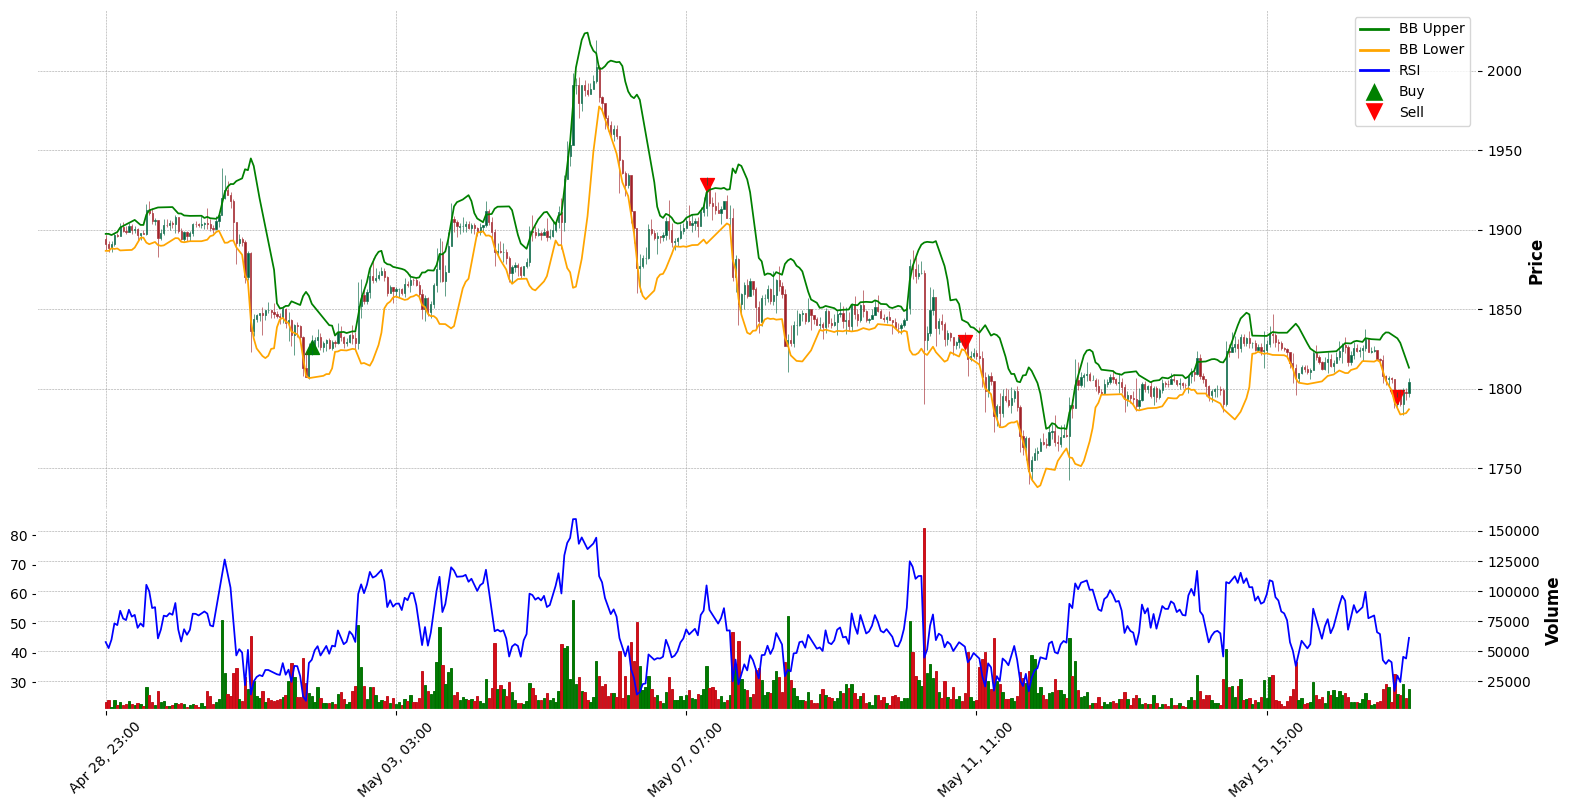

In [26]:

# Load data from CSV file for each fold
df_fold = pd.read_csv("test_results.csv", index_col=0, parse_dates=True)

# Select the desired range of rows
start_index = 8000
end_index = 8450
df_fold_selected = df_fold.iloc[start_index:end_index]

# Create data for buy and sell markers
buy_data = np.full(len(df_fold_selected), np.nan)
buy_data[df_fold_selected['Action'] == 0] = df_fold_selected[df_fold_selected['Action'] == 0]['Close']

sell_data = np.full(len(df_fold_selected), np.nan)
sell_data[df_fold_selected['Action'] == 1] = df_fold_selected[df_fold_selected['Action'] == 1]['Close']

# Create additional plots for indicators
apd = [
    mpf.make_addplot(df_fold_selected['BB_Upper'], color='g'),
    mpf.make_addplot(df_fold_selected['BB_Lower'], color='orange'),
    mpf.make_addplot(df_fold_selected['RSI'], panel=1, color='b'),  # Track RSI over volume
    mpf.make_addplot(buy_data, type='scatter', markersize=100, marker='^', color='g'),
    mpf.make_addplot(sell_data, type='scatter', markersize=100, marker='v', color='r')
]

# Create figure and axes
fig, ax = mpf.plot(df_fold_selected, type='candle', style='charles', volume=True, addplot=apd, figsize=(20, 10), returnfig=True)

# Create custom legend
legend_elements = [
    plt.Line2D([0], [0], color='g', label='BB Upper'),
    plt.Line2D([0], [0], color='orange', label='BB Lower'),
    plt.Line2D([0], [0], color='b', label='RSI'),
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='g', markersize=15, label='Buy'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='r', markersize=15, label='Sell')
]

# Add legend to plot
ax[0].legend(handles=legend_elements)

# Show plot
plt.show()


### 2) Candlestick Chart with Buy, Sell, Take Profit, and Stop Loss Markers (Zoomed-in)

The zoomed-in version of the candlestick chart with buy, sell, take profit, and stop loss markers provides a closer look at the agent's trading decisions and their impact on price movements. This visualization focuses on the most recent data points, allowing for a more detailed analysis of recent trading actions.

By zooming in on a specific timeframe, we can examine the agent's decisions within a narrower context and gain insights into its performance in recent market conditions. The chart also displays the take profit and stop loss levels.


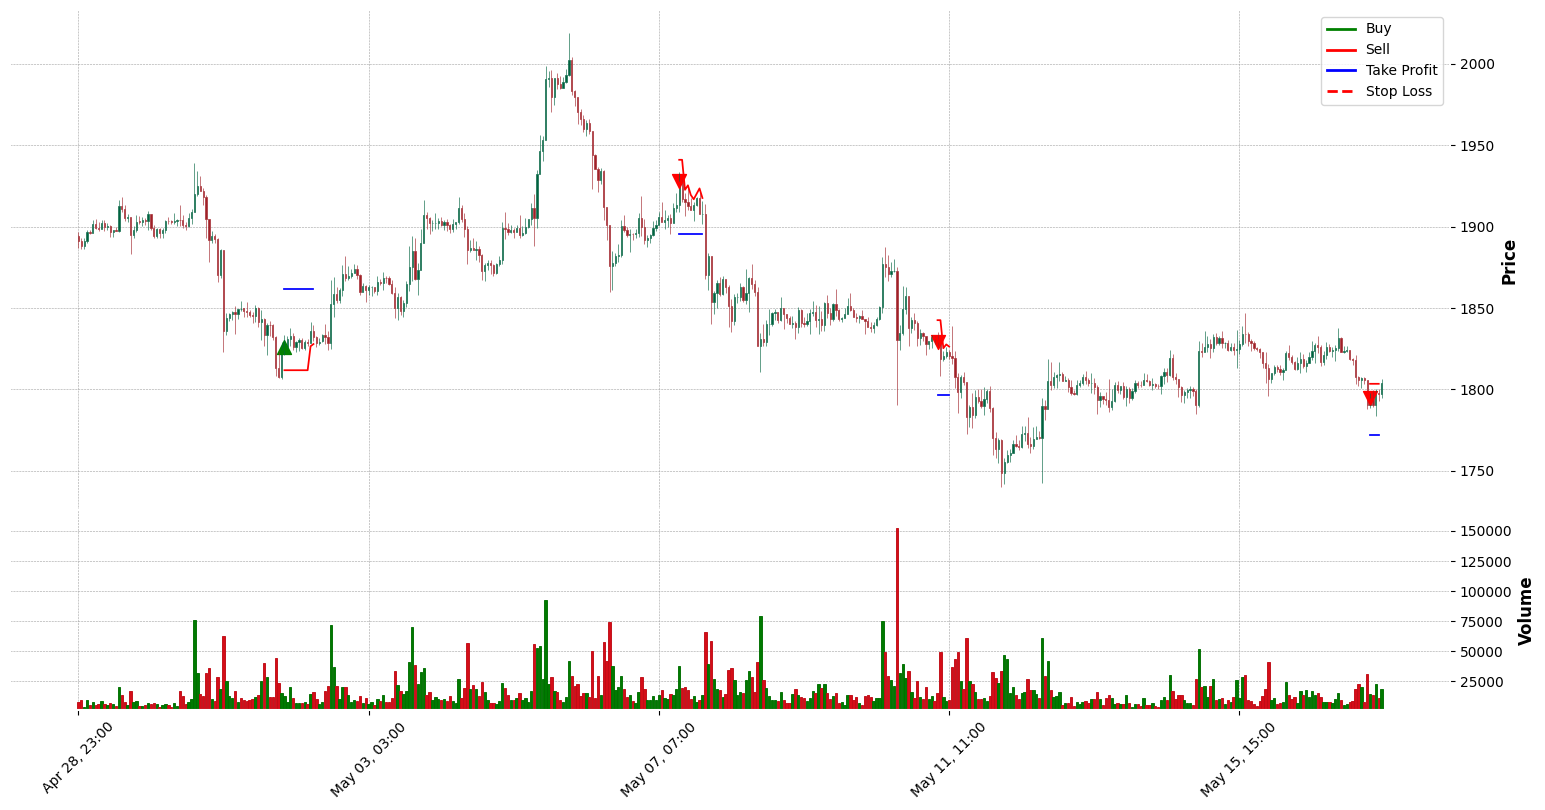

In [27]:

# Load data from CSV file
df_fold = pd.read_csv(f"test_results.csv", index_col=0, parse_dates=True)

# Select the desired range of rows
start_index = 8000
end_index = 8450
df_fold = df_fold.iloc[start_index:end_index]

# Create data for buy and sell markers
buy_data = np.full(len(df_fold), np.nan)
buy_data[df_fold['Action'] == 0] = df_fold[df_fold['Action'] == 0]['Close']

sell_data = np.full(len(df_fold), np.nan)
sell_data[df_fold['Action'] == 1] = df_fold[df_fold['Action'] == 1]['Close']

# Create data for take profit and stop loss levels
take_profit_data = df_fold['Take_Profit']
stop_loss_data = df_fold['Stop_Loss']

# Create smaller markers for buy and sell actions, and line plots for take profit and stop loss levels
apd = [
    mpf.make_addplot(buy_data, type='scatter', markersize=100, marker='^', color='g'),
    mpf.make_addplot(sell_data, type='scatter', markersize=100, marker='v', color='r'),
    mpf.make_addplot(take_profit_data, color='b'),
    mpf.make_addplot(stop_loss_data, color='r')
]

# Create custom legend
legend_elements = [
    plt.Line2D([0], [0], color='g', label='Buy'),
    plt.Line2D([0], [0], color='r', label='Sell'),
    plt.Line2D([0], [0], color='b', label='Take Profit'),
    plt.Line2D([0], [0], color='r', linestyle='--', label='Stop Loss')
]

# Create candlestick chart with  legend
fig, ax = mpf.plot(df_fold_selected, type='candle', style='charles', volume=True, addplot=apd, figsize=(20, 10), returnfig=True)


# Add legend to plot
ax[0].legend(handles=legend_elements)

# Show plot
plt.show()

### 3) Balance Over Time

The balance over time plot showcases the performance of the trading agent in terms of its account balance. It demonstrates how the agent's balance evolves over the duration of the trading period.

This plot enables us to assess the profitability of the agent's trading decisions and identify any significant changes or trends in the balance. Each fold is plotted separately to compare the performance across different folds.


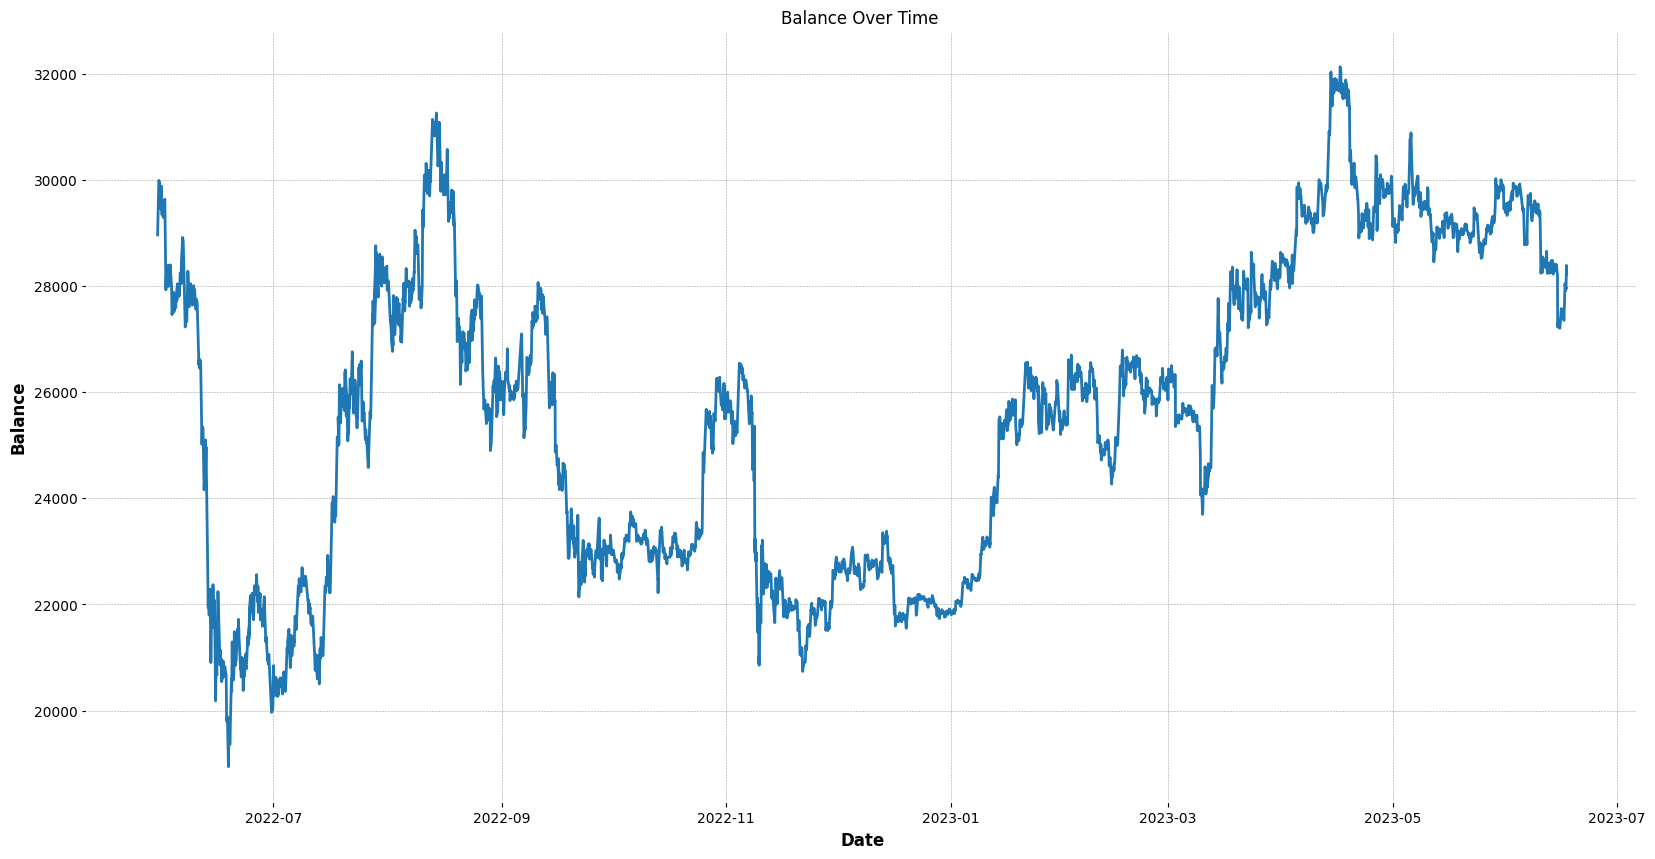

In [28]:

# Load data from CSV file for each fold

df2 = pd.read_csv("test_results.csv", index_col=0, parse_dates=True)

# Plotting
plt.figure(figsize=(20, 10))  # Specify the figure size
plt.plot(df2.index, df2['Balance'])  # Plot Balance
plt.title(f'Balance Over Time ')  # Specify the title
plt.xlabel('Date')  # Specify x-axis label
plt.ylabel('Balance')  # Specify y-axis label
plt.grid(True)  # Add a grid
plt.show()  # Display the plot


### 4) Comparison with Buy-and-Hold Strategy

The comparison plot showcases the performance of the trading agent in comparison with a buy-and-hold strategy. The buy-and-hold strategy assumes purchasing the asset at the initial price and holding it until the end of the trading period.

This plot allows us to assess the agent's performance relative to a passive investment strategy. It helps evaluate whether the agent's active trading approach outperforms or underperforms the buy-and-hold strategy. Each fold is plotted separately to compare the performance across different folds.


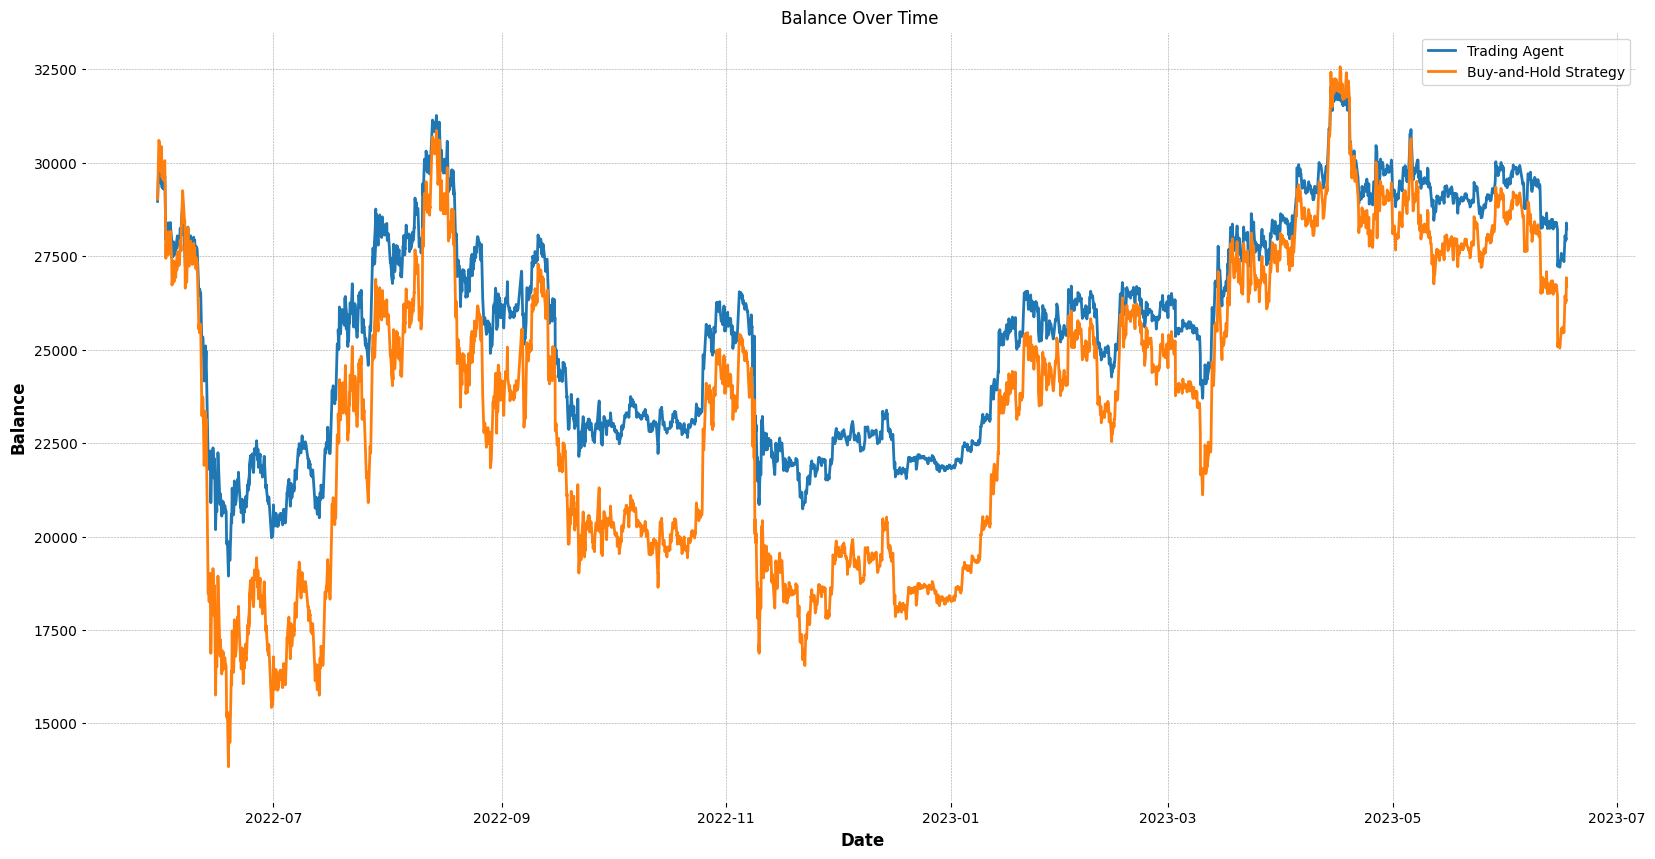

In [29]:

# Load data from CSV file for each fold

df_fold = pd.read_csv(f"test_results.csv", index_col=0, parse_dates=True)

# Compute Buy-and-Hold Strategy Balance
initial_price = df_fold['Open'].iloc[0]  # Get the price at the first time step
initial_balance = df_fold['Balance'].iloc[0]  # Get the initial balance
crypto_purchased = initial_balance / initial_price  # Compute the amount of crypto that would have been purchased

# Compute the value of the buy-and-hold strategy over time
df_fold['BuyAndHoldBalance'] = crypto_purchased * df_fold['Close']

# Plotting
plt.figure(figsize=(20, 10))  # Specify the figure size
plt.plot(df_fold.index, df_fold['Balance'], label='Trading Agent')  # Plot Trading Agent Balance
plt.plot(df_fold.index, df_fold['BuyAndHoldBalance'], label='Buy-and-Hold Strategy')  # Plot Buy-and-Hold Balance
plt.title(f'Balance Over Time ')  # Specify the title
plt.xlabel('Date')  # Specify x-axis label
plt.ylabel('Balance')  # Specify y-axis label
plt.grid(True)  # Add a grid
plt.legend()  # Add a legend
plt.show()  # Display the plot


In [30]:
# Load data from CSV file for each fold

df_fold = pd.read_csv(f"test_results.csv", index_col=0, parse_dates=True)

# Assuming you have a pandas DataFrame named `train_df` that contains the training data
buy_count = (df_fold['Action'] == 0).sum()
sell_count = (df_fold['Action'] == 1).sum()

total_samples = len(df_fold)
buy_percentage = buy_count / total_samples
sell_percentage = sell_count / total_samples

print(f"Buy actions: {buy_count} samples ({buy_percentage:.2%})")
print(f"Sell actions: {sell_count} samples ({sell_percentage:.2%})")

Buy actions: 8 samples (0.09%)
Sell actions: 33 samples (0.36%)
